In [1]:
import cv2
import matplotlib.pyplot as plt

def show_2images(in_pathfile, out_pathfile):
  # Đường dẫn tới hai bức ảnh
  image_path1 = in_pathfile
  image_path2 = out_pathfile

  # Đọc hai bức ảnh
  image1 = cv2.imread(image_path1)  # Đọc bức ảnh thứ nhất
  image2 = cv2.imread(image_path2)  # Đọc bức ảnh thứ hai

  # Chuyển đổi màu sắc từ BGR sang RGB (để matplotlib hiển thị đúng)
  image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
  image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

  # Hiển thị hai bức ảnh cạnh nhau
  plt.figure(figsize=(15, 10))  # Kích thước của hình hiển thị (chiều rộng, chiều cao)

  # Hiển thị bức ảnh thứ nhất bên trái
  plt.subplot(1, 2, 1)
  plt.imshow(image1_rgb)
  # plt.title('INPUT IMAGE')
  plt.title('INPUT IMAGE\n{} x {}'.format(image1_rgb.shape[1], image1_rgb.shape[0]))
  plt.axis('off')  # Tắt trục toạ độ

  # Hiển thị bức ảnh thứ hai bên phải
  plt.subplot(1, 2, 2)
  plt.imshow(image2_rgb)
  # plt.title('OUPUT IMAGE')
  plt.title('OUTPUT IMAGE\n{} x {}'.format(image2_rgb.shape[1], image2_rgb.shape[0]))

  plt.axis('off')  # Tắt trục toạ độ

  plt.show()  # Hiển thị hai bức ảnh cạnh nhau

In [2]:
%%writefile resize_image_GPU_v2.py
import os
from PIL import Image
import numpy as np
import cv2
from numba import jit, njit, cuda
import math
import argparse
import time

# ignore numba warning
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)

BLOCK_SIZE_1D = int(os.environ.get('BLOCK_SIZE_1D', 32))
BLOCK_SIZE_2D = int(os.environ.get('BLOCK_SIZE_2D', 32))

GRAY_IMG_SHAPE = BLOCK_SIZE_1D + 2

def get_image(pathfile):
  img = cv2.imread(pathfile)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

def show_image(img):
  return Image.fromarray(img)

def save_image(img, pathfile):
  cv2.imwrite(pathfile, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

def rotate90_right(img):
  img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  return img

def rotate90_left(img):
  img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
  return img

@cuda.jit
def convert_RGB2Gray_kernel(inImg, outImg, height, width):
  r, c = cuda.grid(2)
  if r < height and c < width:
    outImg[r][c] = inImg[r][c][0]*0.299 + inImg[r][c][1]*0.587 + inImg[r][c][2]*0.114

#////////////////////////////////////////////////////////////////
@cuda.jit
# forward energy
# using share memory
def calc_energy_map_kernel(gray_img, energy_map, height, width, m):
  s_gray_img = cuda.shared.array(shape=(GRAY_IMG_SHAPE, 2), dtype=np.float64)
  c = cuda.grid(1)
  tx = cuda.threadIdx.x
  for idx_row in range(1, height):
    if c < width:
        # Calculate row indices for the pixel above and its neighbors
        up = (idx_row-1) % height
        left = (c-1) % width
        right = (c+1) % width

        # copy data from gray_img to s_gray_img
        if tx == 0:
          s_gray_img[0, 0] = gray_img[idx_row-1, left]
          s_gray_img[1, 0] = gray_img[idx_row, left]

        if tx == BLOCK_SIZE_1D-1:
          s_gray_img[0, BLOCK_SIZE_1D+1] = gray_img[idx_row-1, right]
          s_gray_img[1, BLOCK_SIZE_1D+1] = gray_img[idx_row, right]

        s_gray_img[0, tx+1] = gray_img[idx_row-1, c]
        s_gray_img[1, tx+1] = gray_img[idx_row, c]

        cuda.syncthreads()

        # Retrieve energy accumulated from the pixel above and its neighbors
        mU = m[up, c]
        mL = m[up, left]
        mR = m[up, right]

        cU = abs(s_gray_img[1, tx+2] - s_gray_img[1, tx])
        cL = abs(s_gray_img[0, tx+1] - s_gray_img[1, tx]) + cU
        cR = abs(s_gray_img[0, tx+1] - s_gray_img[1, tx+2]) + cU

        # Update energy
        mU += cU
        mL += cL
        mR += cR

        _mMin = mU
        _cMin = cU

        if mL < _mMin:
            _mMin = mL
            _cMin = cL

        if mR < _mMin:
            _mMin = mR
            _cMin = cR

        # Store the minimum energy
        m[idx_row, c] = _mMin
        energy_map[idx_row, c] = _cMin

        cuda.syncthreads()

#////////////////////////////////////////////////////////////////
@cuda.jit
def get_least_importance_map_kernel(energy_map, least_importance_map, height, width, idx_row):
  c = cuda.grid(1)
  if c < width:
     # Calculate the least importance map for the current row (idx_row)
    if c == 0: # check first column
      least_importance_map[idx_row][c] = min(least_importance_map[idx_row+1,0], least_importance_map[idx_row+1,1]) + energy_map[idx_row][c]
    elif c == width - 1: # check last column
      least_importance_map[idx_row][c] = min(least_importance_map[idx_row+1,width-2], least_importance_map[idx_row+1,width-1]) + energy_map[idx_row][c]
    else:
      least_importance_map[idx_row][c] = min(least_importance_map[idx_row+1,c-1],least_importance_map[idx_row+1,c],least_importance_map[idx_row+1,c+1]) + energy_map[idx_row][c]

#////////////////////////////////////////////////////////////////
@njit
def find_seam(inPixels):
  # Find the index of the minimum energy pixel in the first row
  min_index = np.argmin(inPixels[0])

  height, width = inPixels.shape[:2]
  idxSeam = []
  idxSeam.append(min_index)

  for r in range(1, height):
    # If the minimum energy pixel is in the first column
    if min_index == 0:
      min_index = np.argmin(inPixels[r][min_index:min_index+2])
      idxSeam.append(min_index)
      continue

    # If the minimum energy pixel is in the last column
    if min_index == width - 1:
      min_index = np.argmin(inPixels[r][min_index-1:min_index+1]) + min_index - 1
      idxSeam.append(min_index)
      continue

    # For pixels in the middle columns
    min_index = np.argmin(inPixels[r][min_index-1:min_index+2]) + min_index - 1
    idxSeam.append(min_index)

  return idxSeam

#////////////////////////////////////////////////////////////////
@cuda.jit
def remove_seam_kernel(inImg, pathSeam, height, width, outImg):
  r, c = cuda.grid(2)
  if r < height and c < width:
    if pathSeam[r] <= c:
      for channel in range(3):
        outImg[r][c][channel] = inImg[r][c + 1][channel]
    else:
      for channel in range(3):
        outImg[r][c][channel] = inImg[r][c][channel]


def create_position_matrix(height, width):
    return np.tile(np.arange(width, dtype=np.int16), (height, 1))

#////////////////////////////////////////////////////////////////
@njit
def update_position_matrix(in_matrix, pathSeam):
    height, width = in_matrix.shape

    out_matrix = np.zeros((height, width-1), dtype=np.int16)

    for r in range(height):

      out_matrix[r][:pathSeam[r]] = in_matrix[r][:pathSeam[r]]
      out_matrix[r][pathSeam[r]:] = in_matrix[r][pathSeam[r]+1:]

    return out_matrix
#////////////////////////////////////////////////////////////////
def remove_nSeams(img, nSeams, time_phases):
  # Initialize block sizes for CUDA threads
  block_size_1D = BLOCK_SIZE_1D
  block_size_2D = BLOCK_SIZE_2D, BLOCK_SIZE_2D

  height, width = img.shape[:2]


  for _ in range(nSeams):

    # Calculate grid sizes for CUDA threads
    grid_size_1D = (math.ceil(width / block_size_1D))
    grid_size_2D = (math.ceil(height / block_size_2D[0]),
                    math.ceil(width / block_size_2D[1]))

    # Move input image to the GPU (device)
    d_img = cuda.to_device(img)

    # Allocate device memory
    d_gray_img = cuda.device_array((height, width), dtype=np.float64)
    d_energy_map = cuda.device_array((height, width), dtype=np.float64)
    d_least_importance_map = cuda.device_array((height, width), dtype=np.float64)
    # d_pathSeam = cuda.device_array((height), dtype=np.int16)
    d_out = cuda.device_array((height, width-1, 3), dtype=np.uint8)

    ##########################################
    # Convert the RGB image to grayscale using CUDA kernel
    t = time.perf_counter()
    convert_RGB2Gray_kernel[grid_size_2D, block_size_2D](d_img, d_gray_img, height, width)
    cuda.synchronize()
    time_phases[0] += (time.perf_counter() - t)

    ##########################################
    # Calculate energy map kernel

    d_m = cuda.device_array((height, width), dtype=np.float64)
    t = time.perf_counter()
    calc_energy_map_kernel[grid_size_1D, block_size_1D](d_gray_img, d_energy_map, height, width, d_m)
    cuda.synchronize()
    time_phases[1] += (time.perf_counter() - t)

    ##########################################
    # Calculate least importance map

    d_least_importance_map[height-1][:width] = d_energy_map[height-1][:width]
    t = time.perf_counter()
    for r in range(height-2, -1, -1):
      get_least_importance_map_kernel[grid_size_1D, block_size_1D](d_energy_map, d_least_importance_map, height, width, r)
    cuda.synchronize()
    time_phases[2] += (time.perf_counter() - t)

    ##########################################
    # find seam

    leastImportancePixels = d_least_importance_map.copy_to_host()
    t = time.perf_counter()
    pathSeam = find_seam(leastImportancePixels)
    d_pathSeam = cuda.to_device(pathSeam)
    time_phases[3] += (time.perf_counter() - t)

    ##########################################
    # remove seam
    t = time.perf_counter()

    remove_seam_kernel[grid_size_2D, block_size_2D](d_img, d_pathSeam, height, width-1, d_out)
    cuda.synchronize()
    time_phases[4] += (time.perf_counter() - t)

    # Copy the output image back to the host
    img = d_out.copy_to_host()

    width -= 1
  return img


#////////////////////////////////////////////////////////////////
def insert_seams(img, position_matrix, nSeams):
  height, width = img.shape[:2]

  out_img = np.zeros((height, width + nSeams, 3), dtype=np.uint8)

  for r in range(height):

    position = position_matrix[r]

    for i in range(width-nSeams):
      out_img[r][position[i]*2-i] = img[r][position[i]]

    position_dup = np.setdiff1d(np.arange(width), position)

    for i in range(nSeams):
      out_img[r][position_dup[i]+i] = img[r][position_dup[i]]
      out_img[r][position_dup[i]+i+1] = img[r][position_dup[i]]

  return out_img
#////////////////////////////////////////////////////////////////
def insert_nSeams(img, nSeams, ratio_default, time_phases):
  # Initialize block sizes for CUDA threads
  block_size_1D = BLOCK_SIZE_1D
  block_size_2D = BLOCK_SIZE_2D, BLOCK_SIZE_2D

  height, width = img.shape[:2]
  ratio_resize = nSeams / width

  if ratio_resize <= ratio_default:
    position_matrix = create_position_matrix(height, width)
    tmp_img = img.copy()
    for _ in range(nSeams):
      # Calculate grid sizes for CUDA threads
      grid_size_1D = (math.ceil(width / block_size_1D))
      grid_size_2D = (math.ceil(height / block_size_2D[0]),
                      math.ceil(width / block_size_2D[1]))

      # Move input image to the GPU (device)
      d_img = cuda.to_device(tmp_img)

      # Allocate device memory
      d_gray_img = cuda.device_array((height, width), dtype=np.float64)
      d_energy_map = cuda.device_array((height, width), dtype=np.float64)
      d_least_importance_map = cuda.device_array((height, width), dtype=np.float64)
      # d_pathSeam = cuda.device_array((height), dtype=np.int16)
      d_out = cuda.device_array((height, width-1, 3), dtype=np.uint8)

      ##########################################
      # Convert the RGB image to grayscale using CUDA kernel
      t = time.perf_counter()
      convert_RGB2Gray_kernel[grid_size_2D, block_size_2D](d_img, d_gray_img, height, width)
      cuda.synchronize()
      time_phases[0] += (time.perf_counter() - t)
      ##########################################
      # Calculate energy map kernel

      d_m = cuda.device_array((height, width), dtype=np.float64)
      t = time.perf_counter()
      calc_energy_map_kernel[grid_size_1D, block_size_1D](d_gray_img, d_energy_map, height, width, d_m)
      cuda.synchronize()
      time_phases[1] += (time.perf_counter() - t)
      ##########################################
      # Calculate least importance map

      d_least_importance_map[height-1][:width] = d_energy_map[height-1][:width]
      t = time.perf_counter()
      for r in range(height-2, -1, -1):
        get_least_importance_map_kernel[grid_size_1D, block_size_1D](d_energy_map, d_least_importance_map, height, width, r)
      cuda.synchronize()
      time_phases[2] += (time.perf_counter() - t)
      ##########################################
      # find seam
      t = time.perf_counter()
      leastImportancePixels = d_least_importance_map.copy_to_host()
      pathSeam = find_seam(leastImportancePixels)
      time_phases[3] += (time.perf_counter() - t)
      d_pathSeam = cuda.to_device(pathSeam)

      ##########################################
      position_matrix = update_position_matrix(position_matrix, pathSeam)
      ##########################################
      # remove seam
      t = time.perf_counter()
      remove_seam_kernel[grid_size_2D, block_size_2D](d_img, d_pathSeam, height, width-1, d_out)
      cuda.synchronize()
      time_phases[4] += (time.perf_counter() - t)
      # Copy the output image back to the host
      tmp_img = d_out.copy_to_host()

      width -= 1
      cuda.synchronize()
    t = time.perf_counter()
    img = insert_seams(img, position_matrix, nSeams)
    time_phases[5] += (time.perf_counter() - t)
  else:
    kSeams = int(width * ratio_default)
    img = insert_nSeams(img, kSeams, ratio_default,time_phases)
    img = insert_nSeams(img, nSeams - kSeams, ratio_default,time_phases)
  return img
#////////////////////////////////////////////////////////////////
if __name__ == '__main__':
  print("Resize image GPU v2\n")
  # Tạo đối tượng ArgumentParser
  parser = argparse.ArgumentParser()

  # Thêm các đối số và tùy chọn
  parser.add_argument("-input", type=str, help='path file input')
  parser.add_argument('-output', type=str, help='path file output')

  parser.add_argument('-dx', type=int, help='number of seams - axis x', default = 0)
  parser.add_argument('-dy', type=int, help='number of seams - axis y', default = 0)

  parser.add_argument('-ratio_resize', type=float, help='ratio resize image (0->1) ', default = 0.5)

  # Phân tích các tham số dòng lệnh
  args = parser.parse_args()

  img = get_image(args.input)
  print("INPUT:", img.shape)
  time_phases = np.zeros(6)
  start = time.perf_counter()
  if args.dx < 0:
    img = remove_nSeams(img, abs(args.dx), time_phases)

  if args.dy < 0:
    img = rotate90_left(img)
    img = remove_nSeams(img, abs(args.dy), time_phases)
    img = rotate90_right(img)

  if args.dx > 0:
      img = insert_nSeams(img, args.dx, args.ratio_resize, time_phases)

  if args.dy > 0:
    img = rotate90_left(img)
    img = insert_nSeams(img, args.dy, args.ratio_resize, time_phases)
    img = rotate90_right(img)

  end = time.perf_counter()
  print("OUTPUT:", img.shape)

  print("\nRUNTIME PHASES:")
  print("- Convert RGB -> gray:",round(time_phases[0],3),"seconds")
  print("- Calc energy map:",round(time_phases[1],3),"seconds")
  print("- Calc least importance map:", round(time_phases[2],3),"seconds")
  print("- Find seam:", round(time_phases[3],3),"seconds")
  print("- Remove seam:", round(time_phases[4],3),"seconds")
  print("- Insert seam:", round(time_phases[5],3),"seconds")
  print("- Other functions:", round(end - start - sum(time_phases),3),"seconds")

  print("\nTOTAL RUNTIME:",round(end - start,3), "seconds")

  save_image(img, args.output)

Overwriting resize_image_GPU_v2.py


In [6]:
!python resize_image_GPU_v2.py -input "/content/original.jpg" -output "/content/insert_100rows_remove_100cols.jpg" -dx 100 -dy -100

Resize image GPU v2

INPUT: (434, 640, 3)
OUTPUT: (334, 740, 3)

RUNTIME PHASES:
- Convert RGB -> gray: 0.265 seconds
- Calc energy map: 0.702 seconds
- Calc least importance map: 6.143 seconds
- Find seam: 0.741 seconds
- Remove seam: 0.174 seconds
- Insert seam: 0.549 seconds
- Other functions: 1.716 seconds

TOTAL RUNTIME: 10.29 seconds


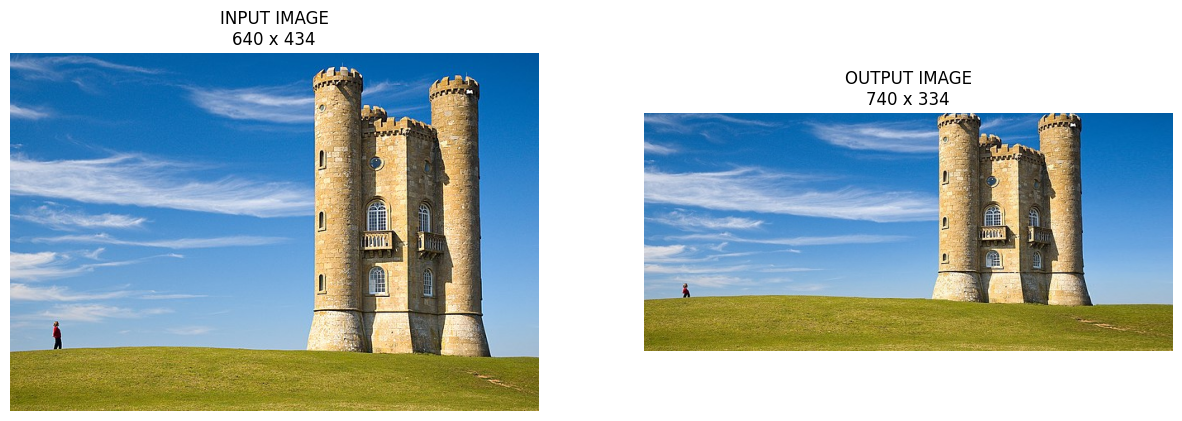

In [4]:
show_2images("/content/original.jpg","/content/insert_100rows_remove_100cols.jpg")